In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns


,ID,AL,ACD,WTW,K1,K2,Correto
0,0,23.79,3.32,12.0,43.60,44.29,S
1,1,24.60,3.39,12.3,42.03,43.95,S
2,2,24.59,3.51,12.3,42.83,43.05,S
3,3,24.04,2.96,12.0,42.35,42.83,S
4,4,24.80,2.44,12.2,41.01,41.67,S
...,...,...,...,...,...,...,...
1523,1523,23.32,3.29,12.5,43.16,43.95,S
1524,1524,23.59,3.19,13.0,42.72,43.60,N
1525,1525,26.18,3.83,12.1,43.44,44.18,S
1526,1526,24.09,2.77,12.6,42.83,43.72,S


,ID,AL,ACD,WTW,K1,K2
count,1528.00000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000
mean,763.50000,23.486525,3.106728,11.975098,43.469188,44.370386
std,441.23992,1.142280,0.428881,0.431712,1.745504,1.767765
min,0.00000,20.150000,1.130000,9.900000,30.930000,33.950000
25%,381.75000,22.760000,2.830000,11.700000,42.450000,43.270000
50%,763.50000,23.360000,3.080000,12.000000,43.490000,44.290000
75%,1145.25000,24.080000,3.360000,12.300000,44.530000,45.490000
max,1527.00000,30.960000,5.230000,13.300000,49.410000,52.410000


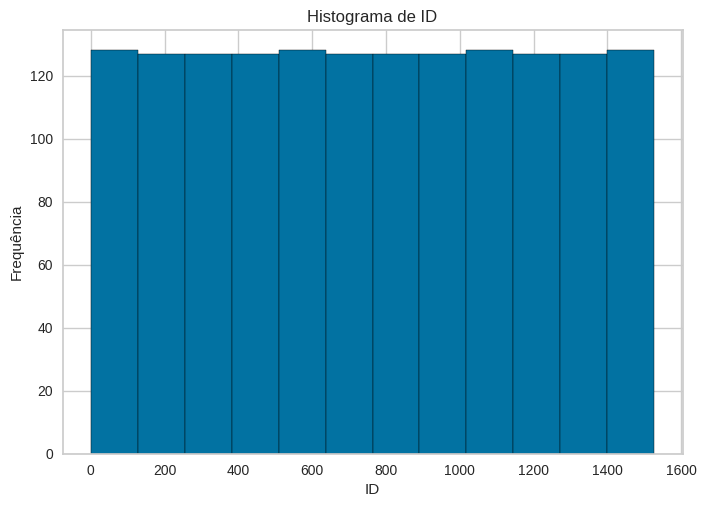

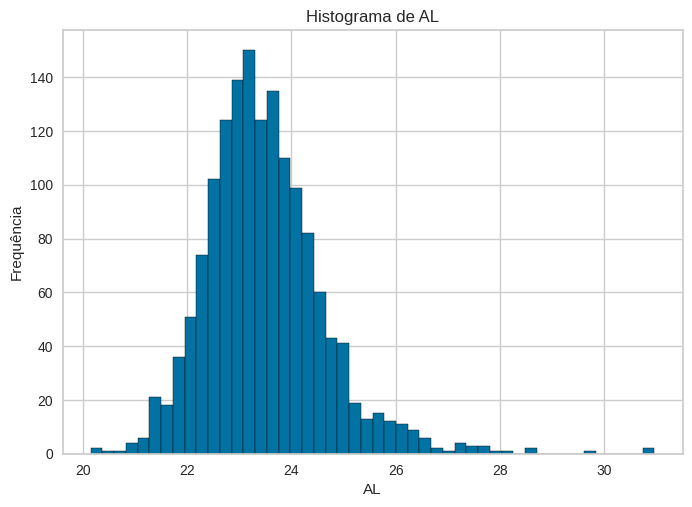

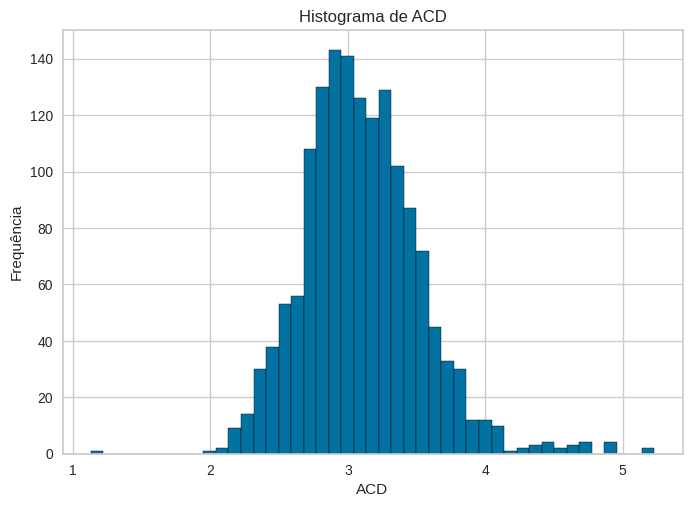

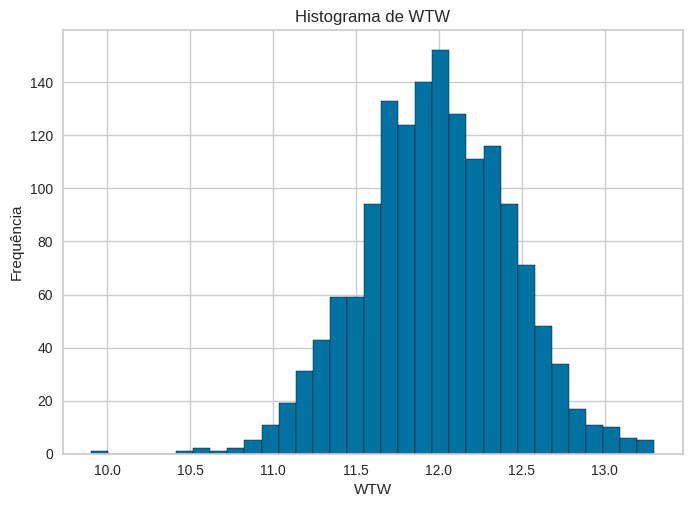

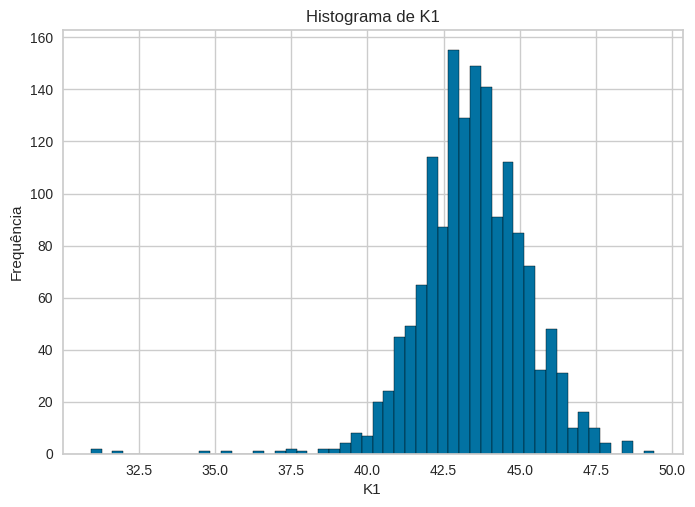

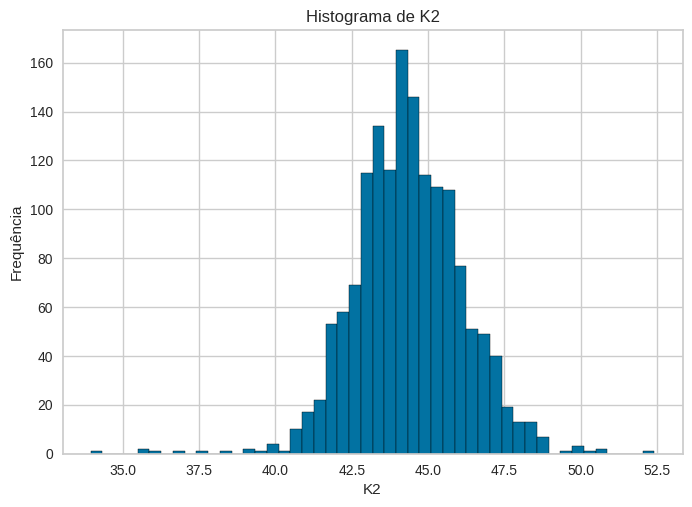

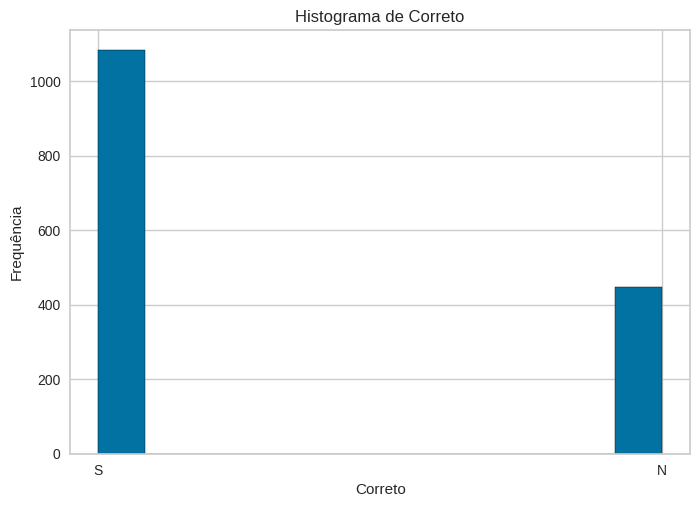

In [10]:


df = pd.read_excel('barrettII_eyes_clustering.xlsx')
display(df)
display(df.describe())
for col in df.columns:
    plt.figure()  # Cria uma nova figura para cada histograma
    plt.hist(df[col], bins='auto', edgecolor='black')  # Cria um histograma para a coluna
    plt.title(f'Histograma de {col}')  # Define o título com o nome da coluna
    plt.xlabel(col)  # Define o rótulo do eixo x com o nome da coluna
    plt.ylabel('Frequência')  # Define o rótulo do eixo y
    plt.show() 

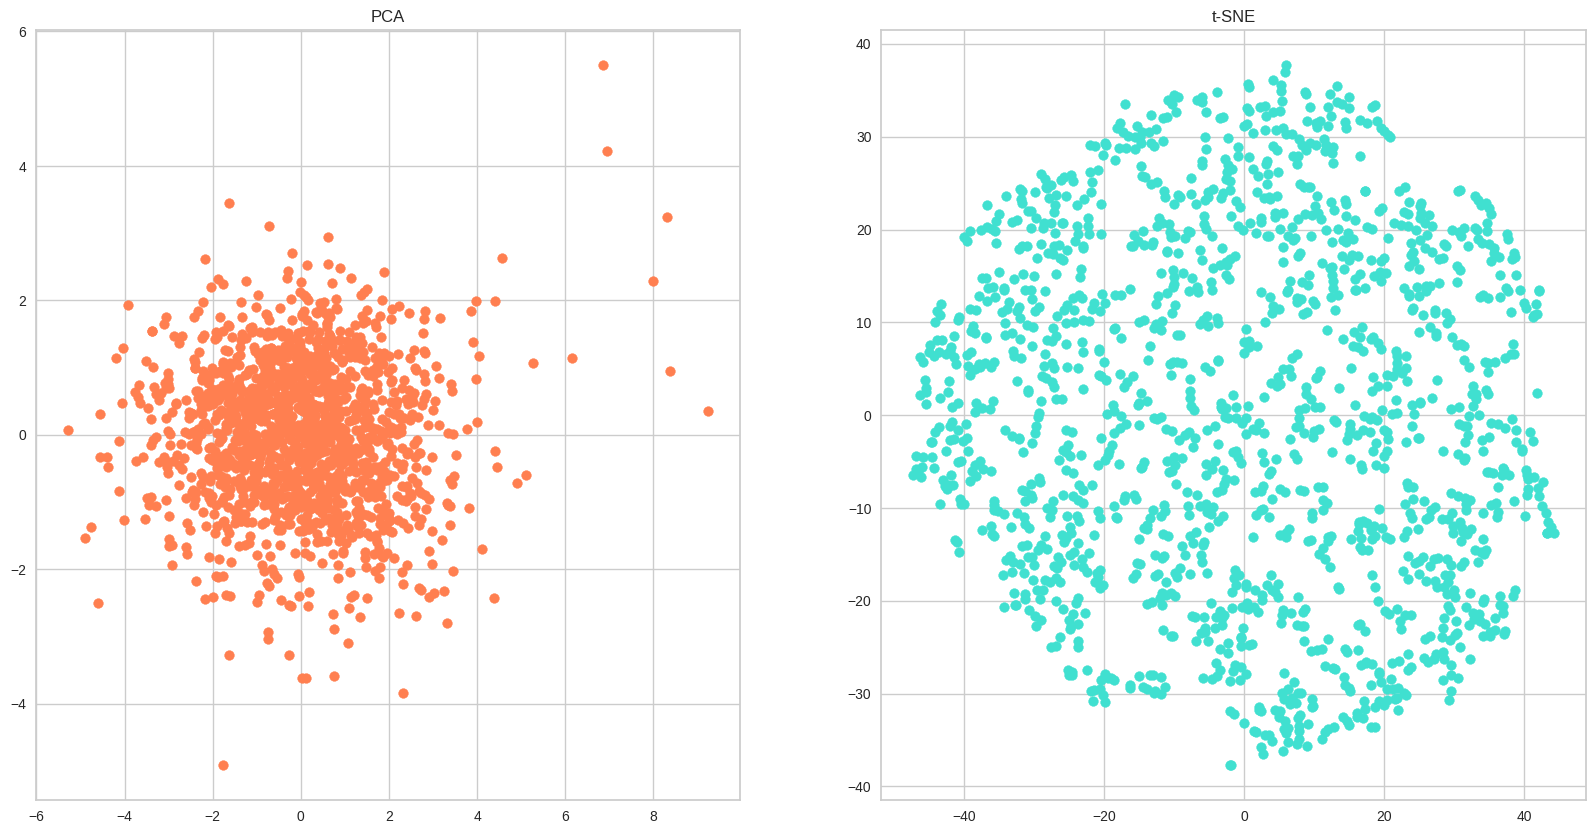

In [11]:
# Visualizando os dados utilizando o PCA e T-SNE

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.drop(['Correto'], axis=1))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# Plotando os resultados
plt.figure(figsize=(20, 10))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='coral')
plt.title('PCA')

# t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color='turquoise')
plt.title('t-SNE')

plt.show()

In [12]:
# Calculando o melhor valor de k na mão
from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

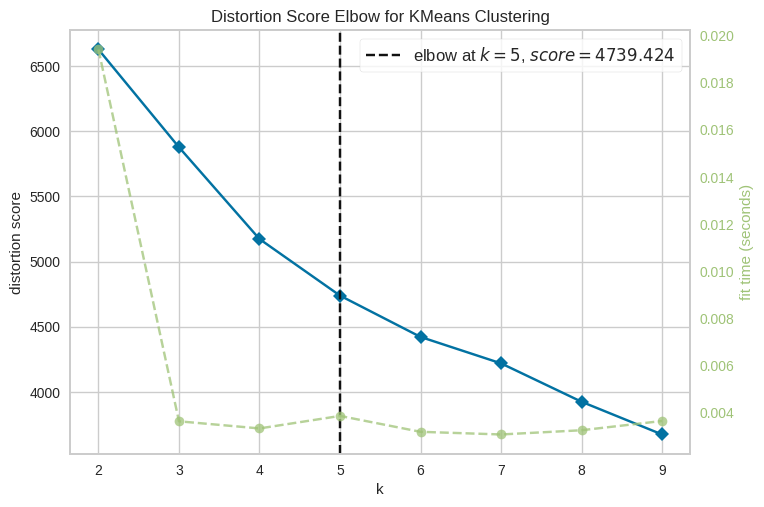

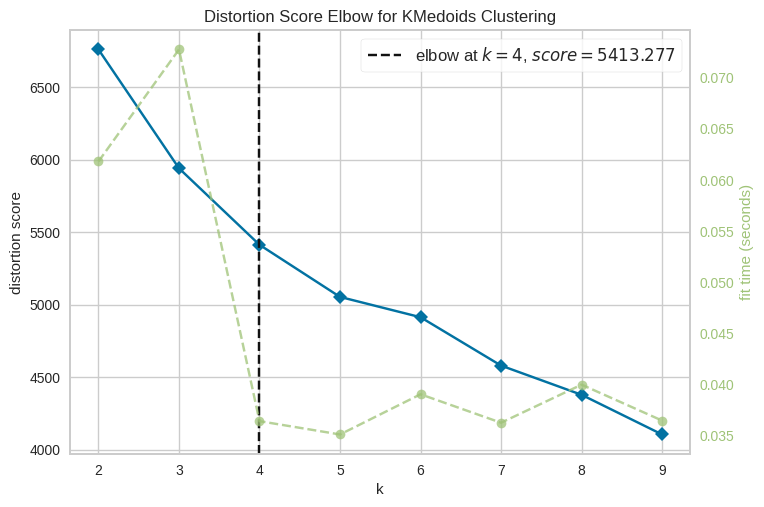

In [13]:
def better_k(model, data):
    visualizer = KElbowVisualizer(model(random_state=42), k=(2,10) ) #type: ignore
    visualizer.fit(data)        # Fit the data to the visualizer
    visualizer.show() ;
better_k(KMeans, data_scaled)
better_k(KMedoids, data_scaled)

In [14]:
# Para cada valor de k, execute o K-means e visualize os agrupamentos
metrics_model = {'Model':[],
                 'K':[],
                 'Silhouette Score':[],
                 'Davies-Bouldin Score':[],
                 'inertia':[],
                 'result':[]}

def clusters_plot(k_values: list[int], data, model) -> None:
    for k in k_values:
        # Executar K-means
        model_custom = model(n_clusters=k, random_state=42)
        clusters = model_custom.fit_predict(data)
        
        # Metricas
        metrics_model['Model'].append(type(model_custom).__name__)
        metrics_model['K'].append(k)
        metrics_model['Silhouette Score'].append(silhouette_score(data, clusters))
        metrics_model['Davies-Bouldin Score'].append(davies_bouldin_score(data, clusters))
        metrics_model['inertia'].append(model_custom.inertia_)
        metrics_model['result'].append(clusters)
        

        # Reduzir a dimensionalidade com PCA
        pca = PCA(n_components=2, random_state=42)
        pca_result = pca.fit_transform(data)
        
        # Reduzir a dimensionalidade com t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(data)
        
        # Plotar os resultados do PCA
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='plasma')
        plt.title(f'PCA - K = {k}: {type(model_custom).__name__}')
        plt.colorbar()
        
        # Plotar os resultados do t-SNE
        plt.subplot(1, 2, 2)
        plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='plasma')
        plt.title(f't-SNE - K = {k}: {type(model_custom).__name__}')
        plt.colorbar()
        
        plt.tight_layout()
        plt.show()
        


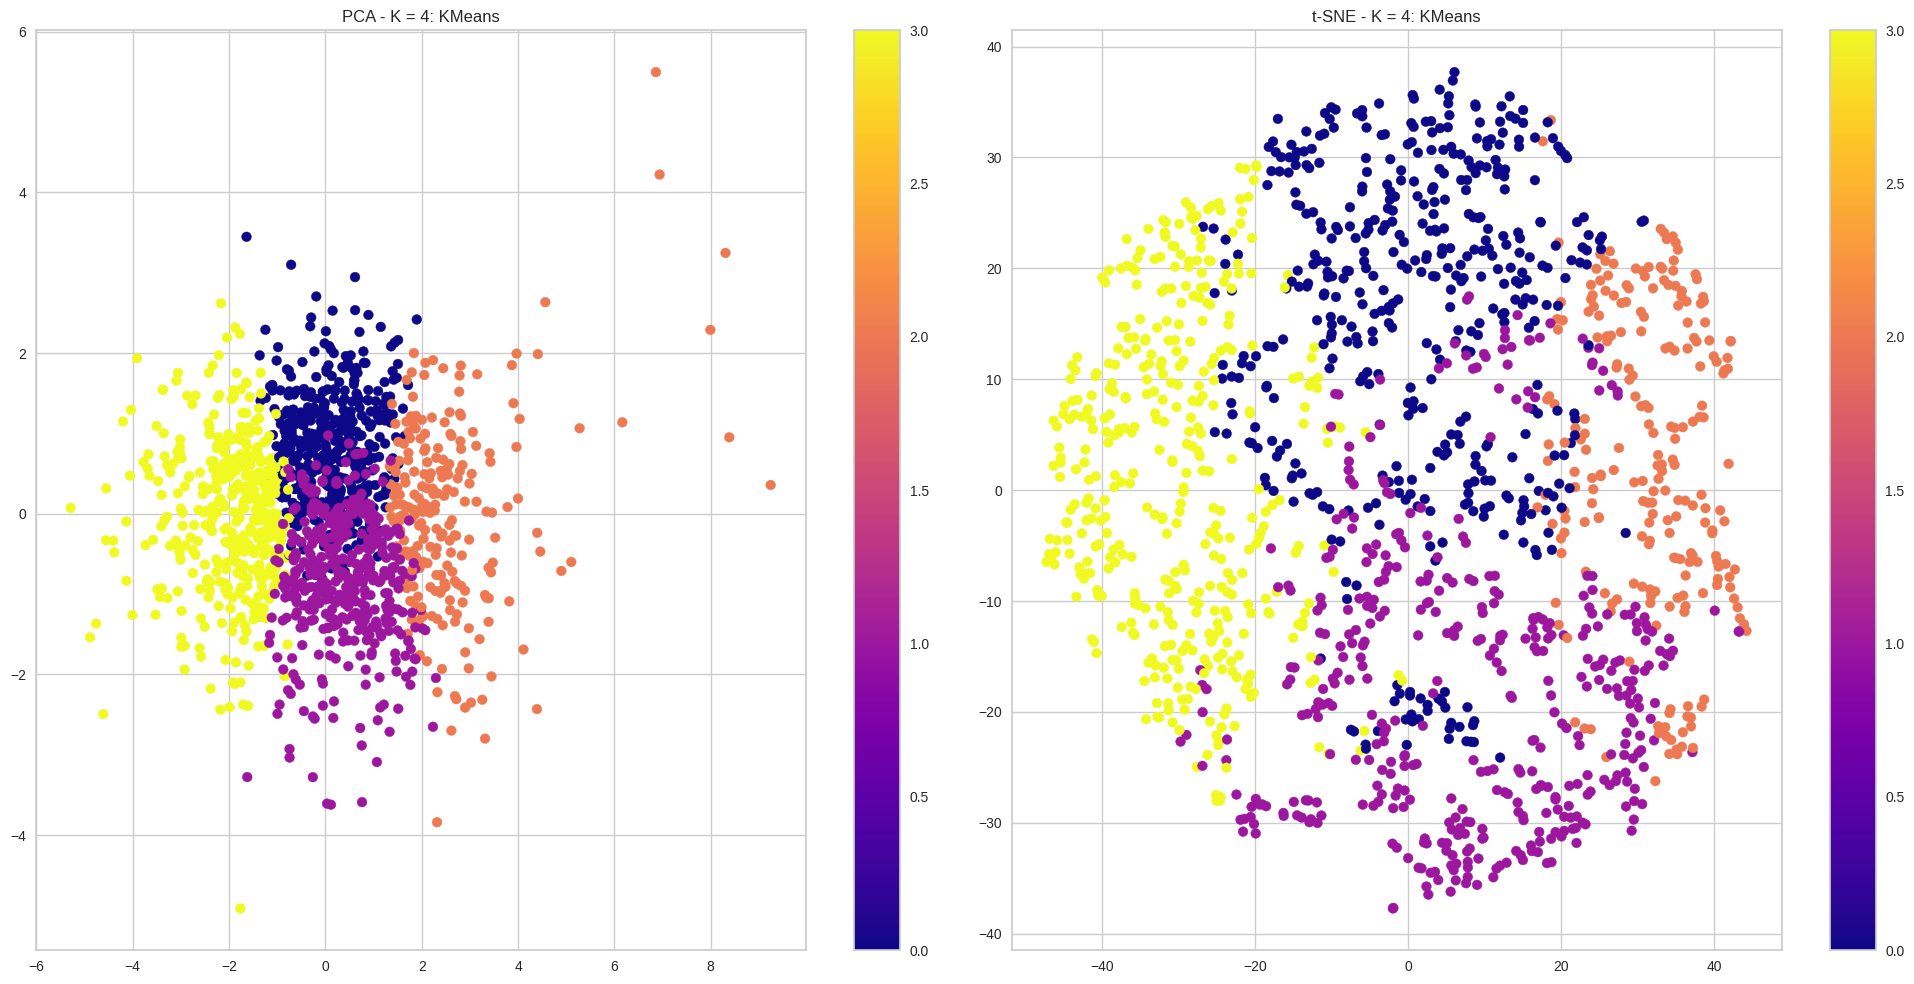

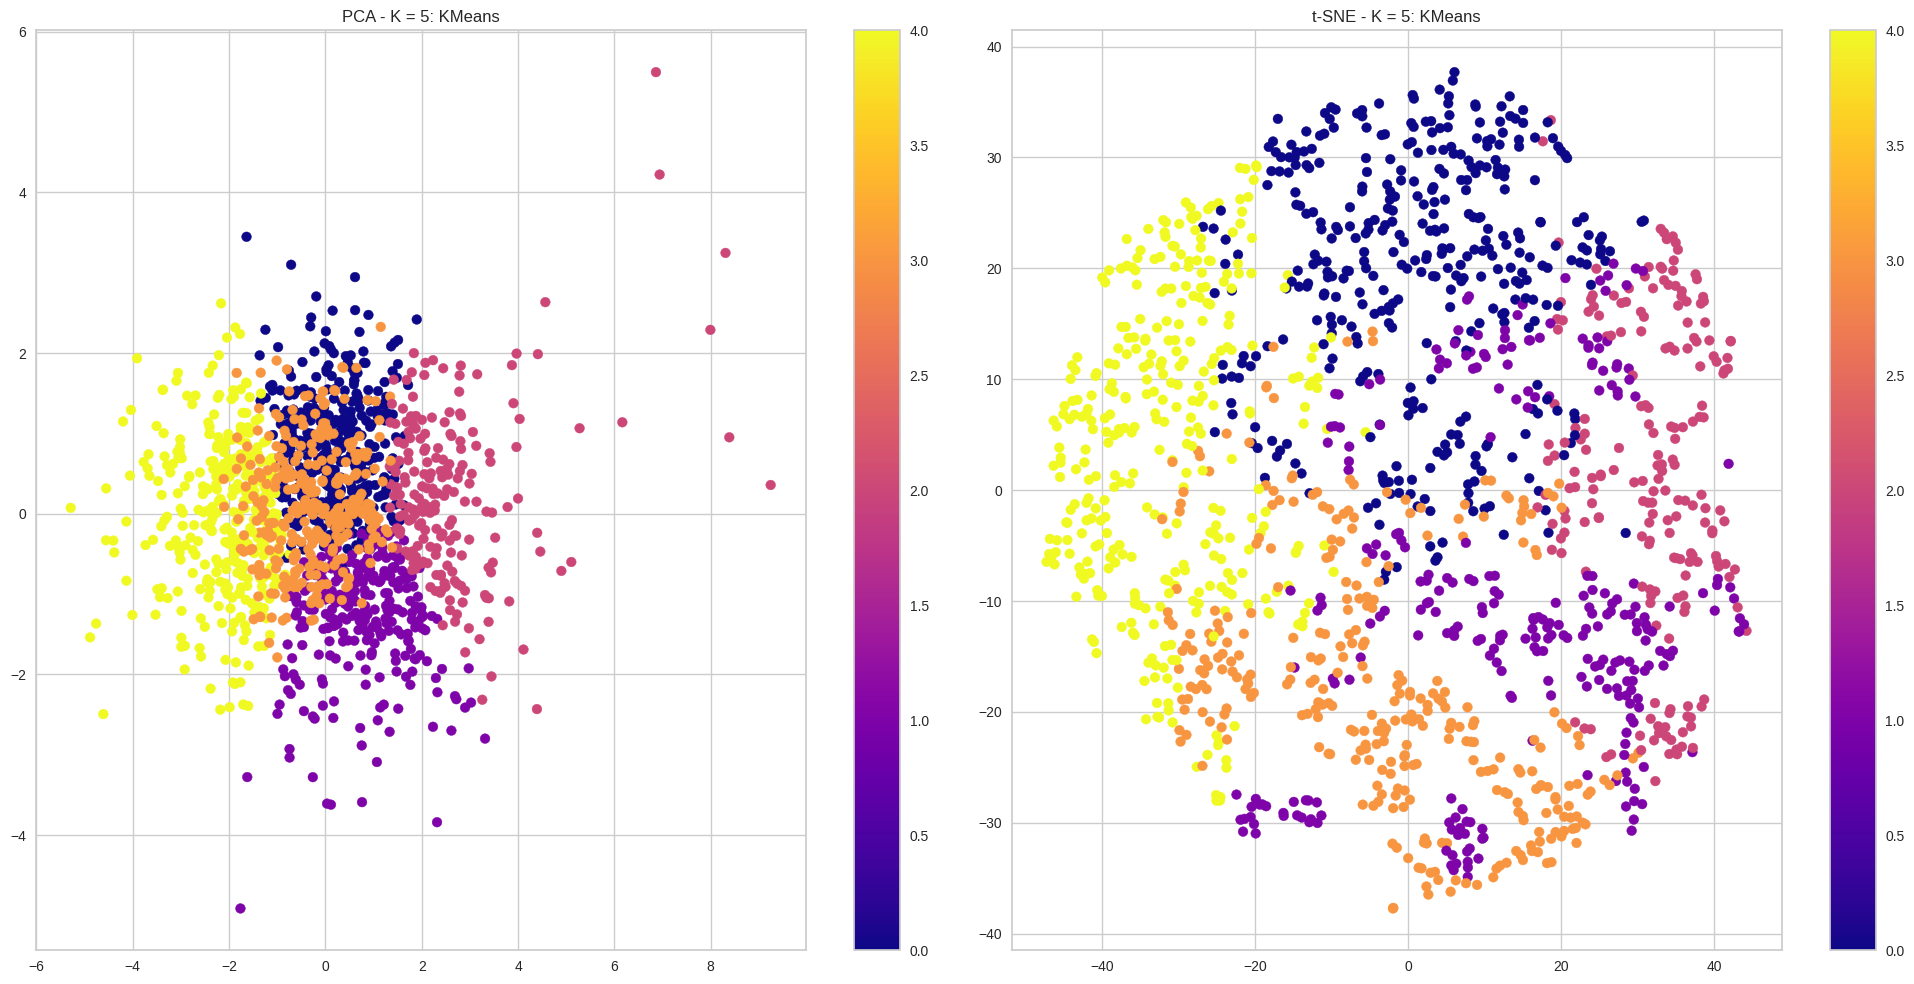

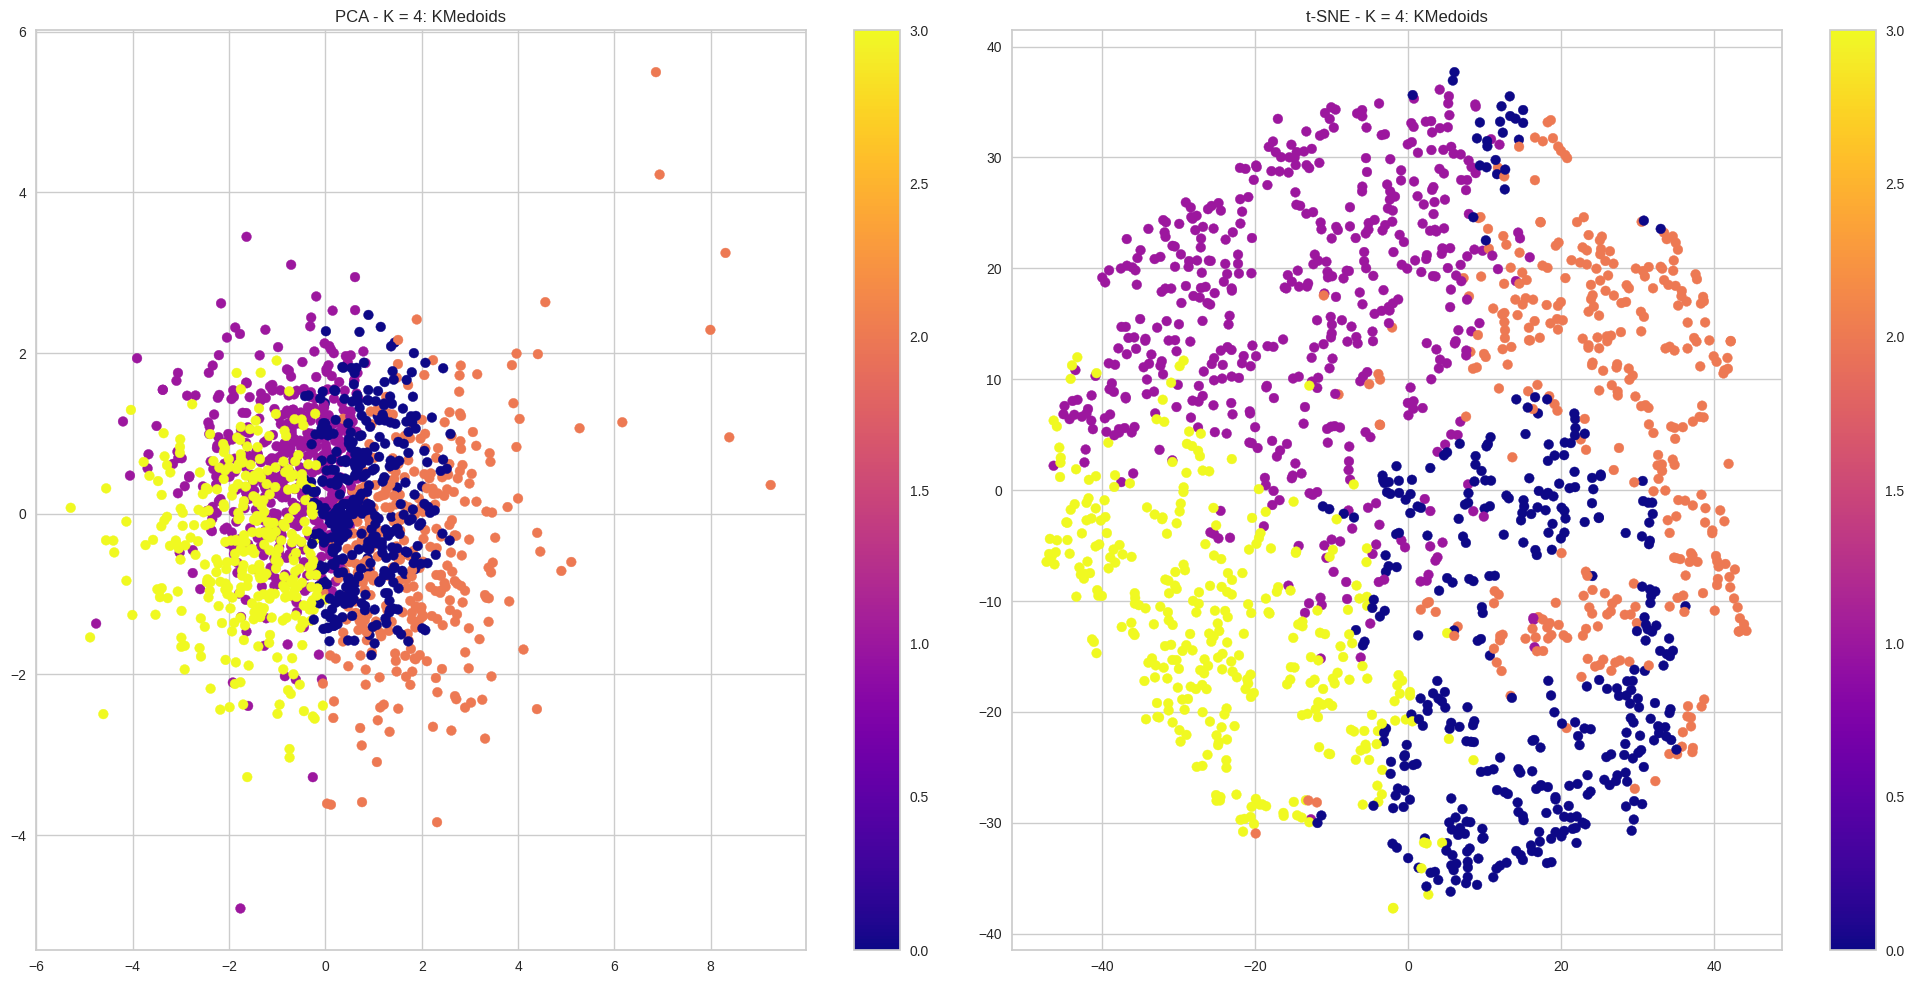

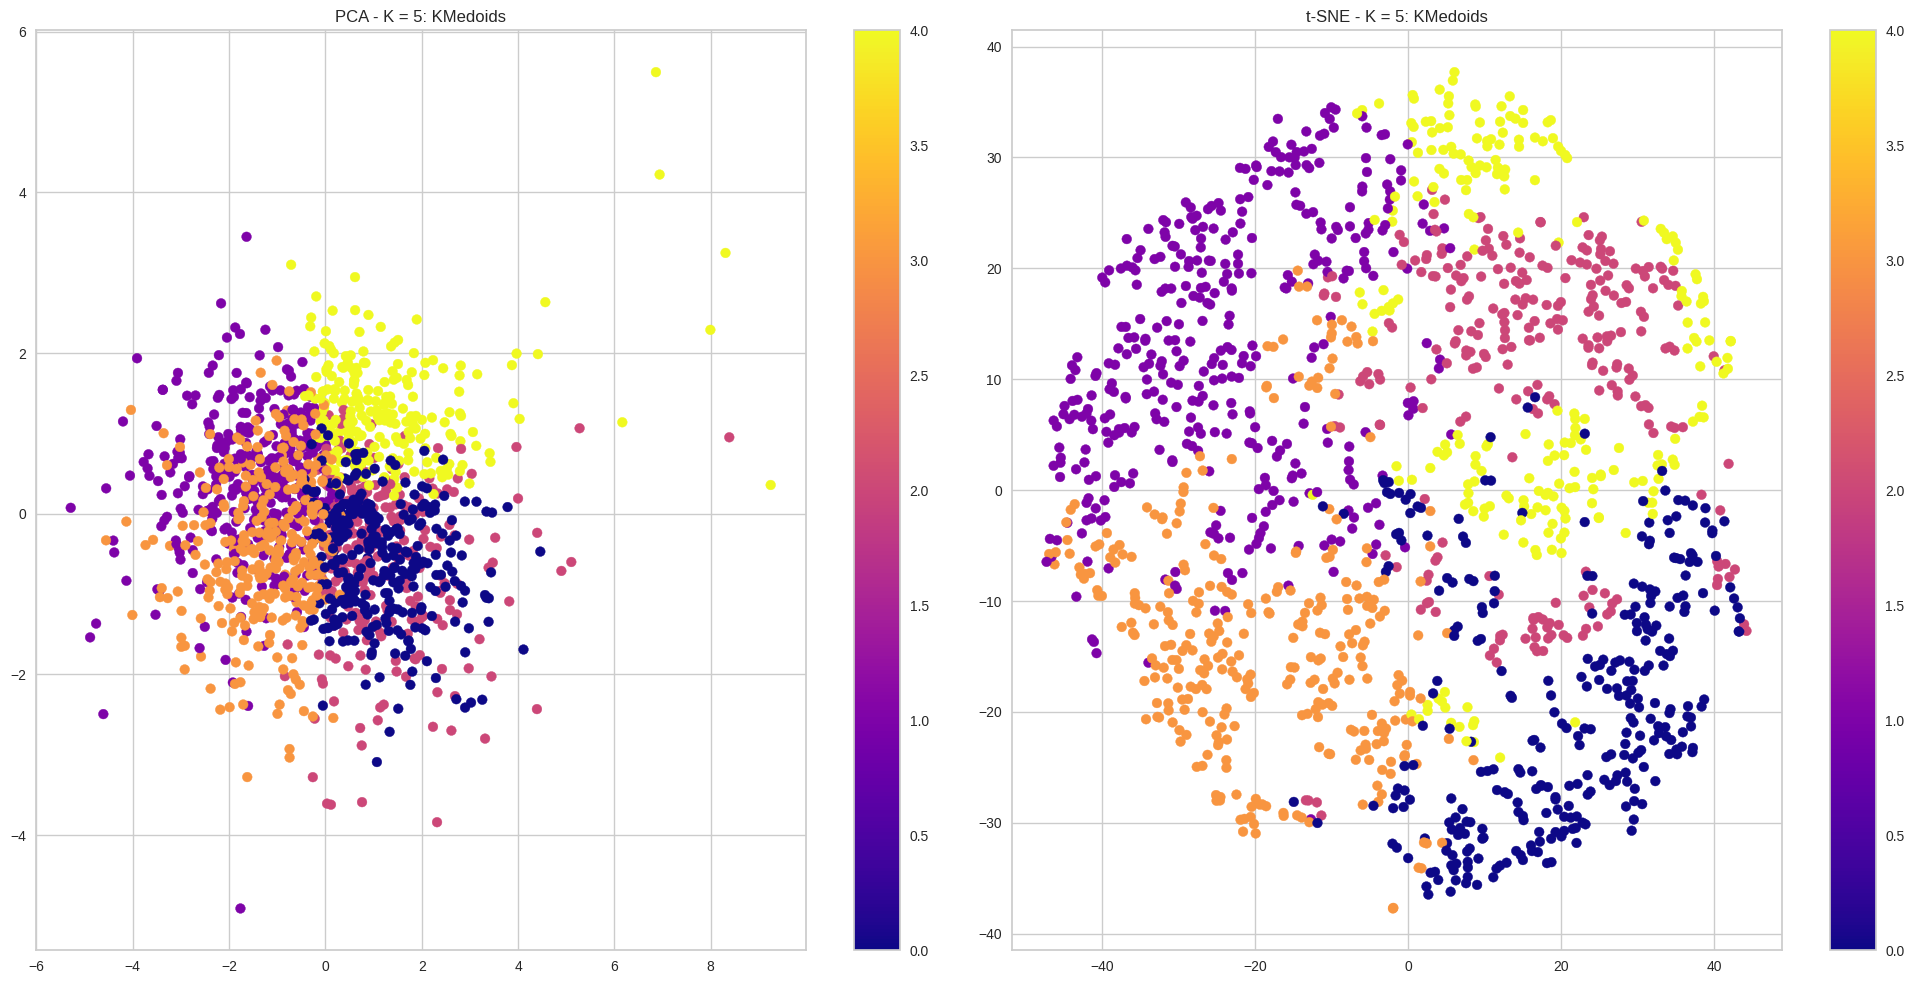

In [15]:
k_values = [4, 5]
clusters_plot(k_values,data_scaled, KMeans)
clusters_plot(k_values,data_scaled, KMedoids)

In [16]:
df_metrics = pd.DataFrame(metrics_model)
df_metrics

,Model,K,Silhouette Score,Davies-Bouldin Score,inertia,result
0,KMeans,4,0.176164,1.577454,5173.404887,"[0, 2, 2, 0, 0, 3, 0, 2, 0, 3, 2, 0, 0, 3, 1, ..."
1,KMeans,5,0.165369,1.486909,4739.570186,"[0, 0, 0, 0, 0, 4, 0, 2, 0, 4, 2, 0, 0, 4, 1, ..."
2,KMedoids,4,0.149696,1.840359,2671.371265,"[1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, ..."
3,KMedoids,5,0.153468,1.781229,2568.424996,"[2, 2, 2, 4, 4, 1, 1, 4, 4, 1, 2, 1, 1, 1, 2, ..."


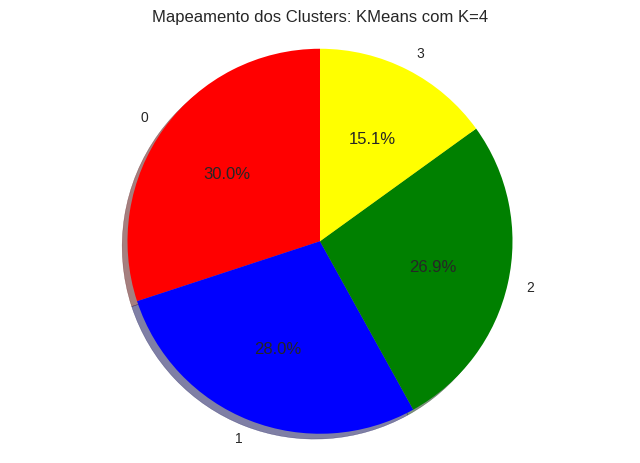

In [17]:

freq_k4 = pd.DataFrame(df_metrics['result'][0]).value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(freq_k4, autopct='%1.1f%%', labels=['0', '1', '2', '3'], shadow=True, startangle=90, colors=['red', 'blue', 'green', 'yellow'])
ax1.axis('equal')
ax1.set_title('Mapeamento dos Clusters: KMeans com K=4')
plt.show()

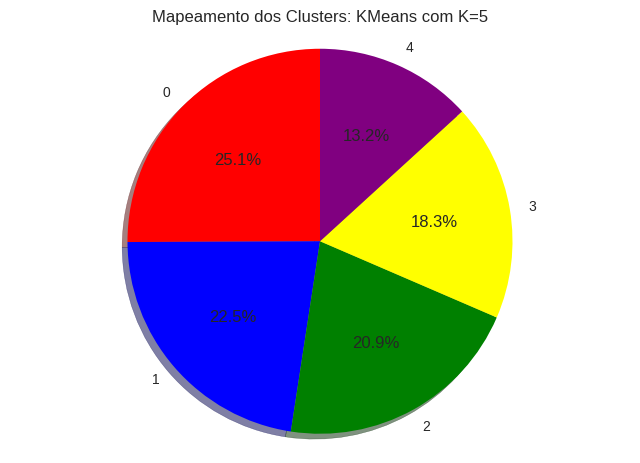

In [18]:
freq_k5 = pd.DataFrame(df_metrics['result'][1]).value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(freq_k5, autopct='%1.1f%%', labels=['0', '1', '2', '3', '4'], shadow=True, startangle=90, colors=['red', 'blue', 'green', 'yellow', 'purple'])
ax1.axis('equal')
ax1.set_title('Mapeamento dos Clusters: KMeans com K=5')
plt.show()

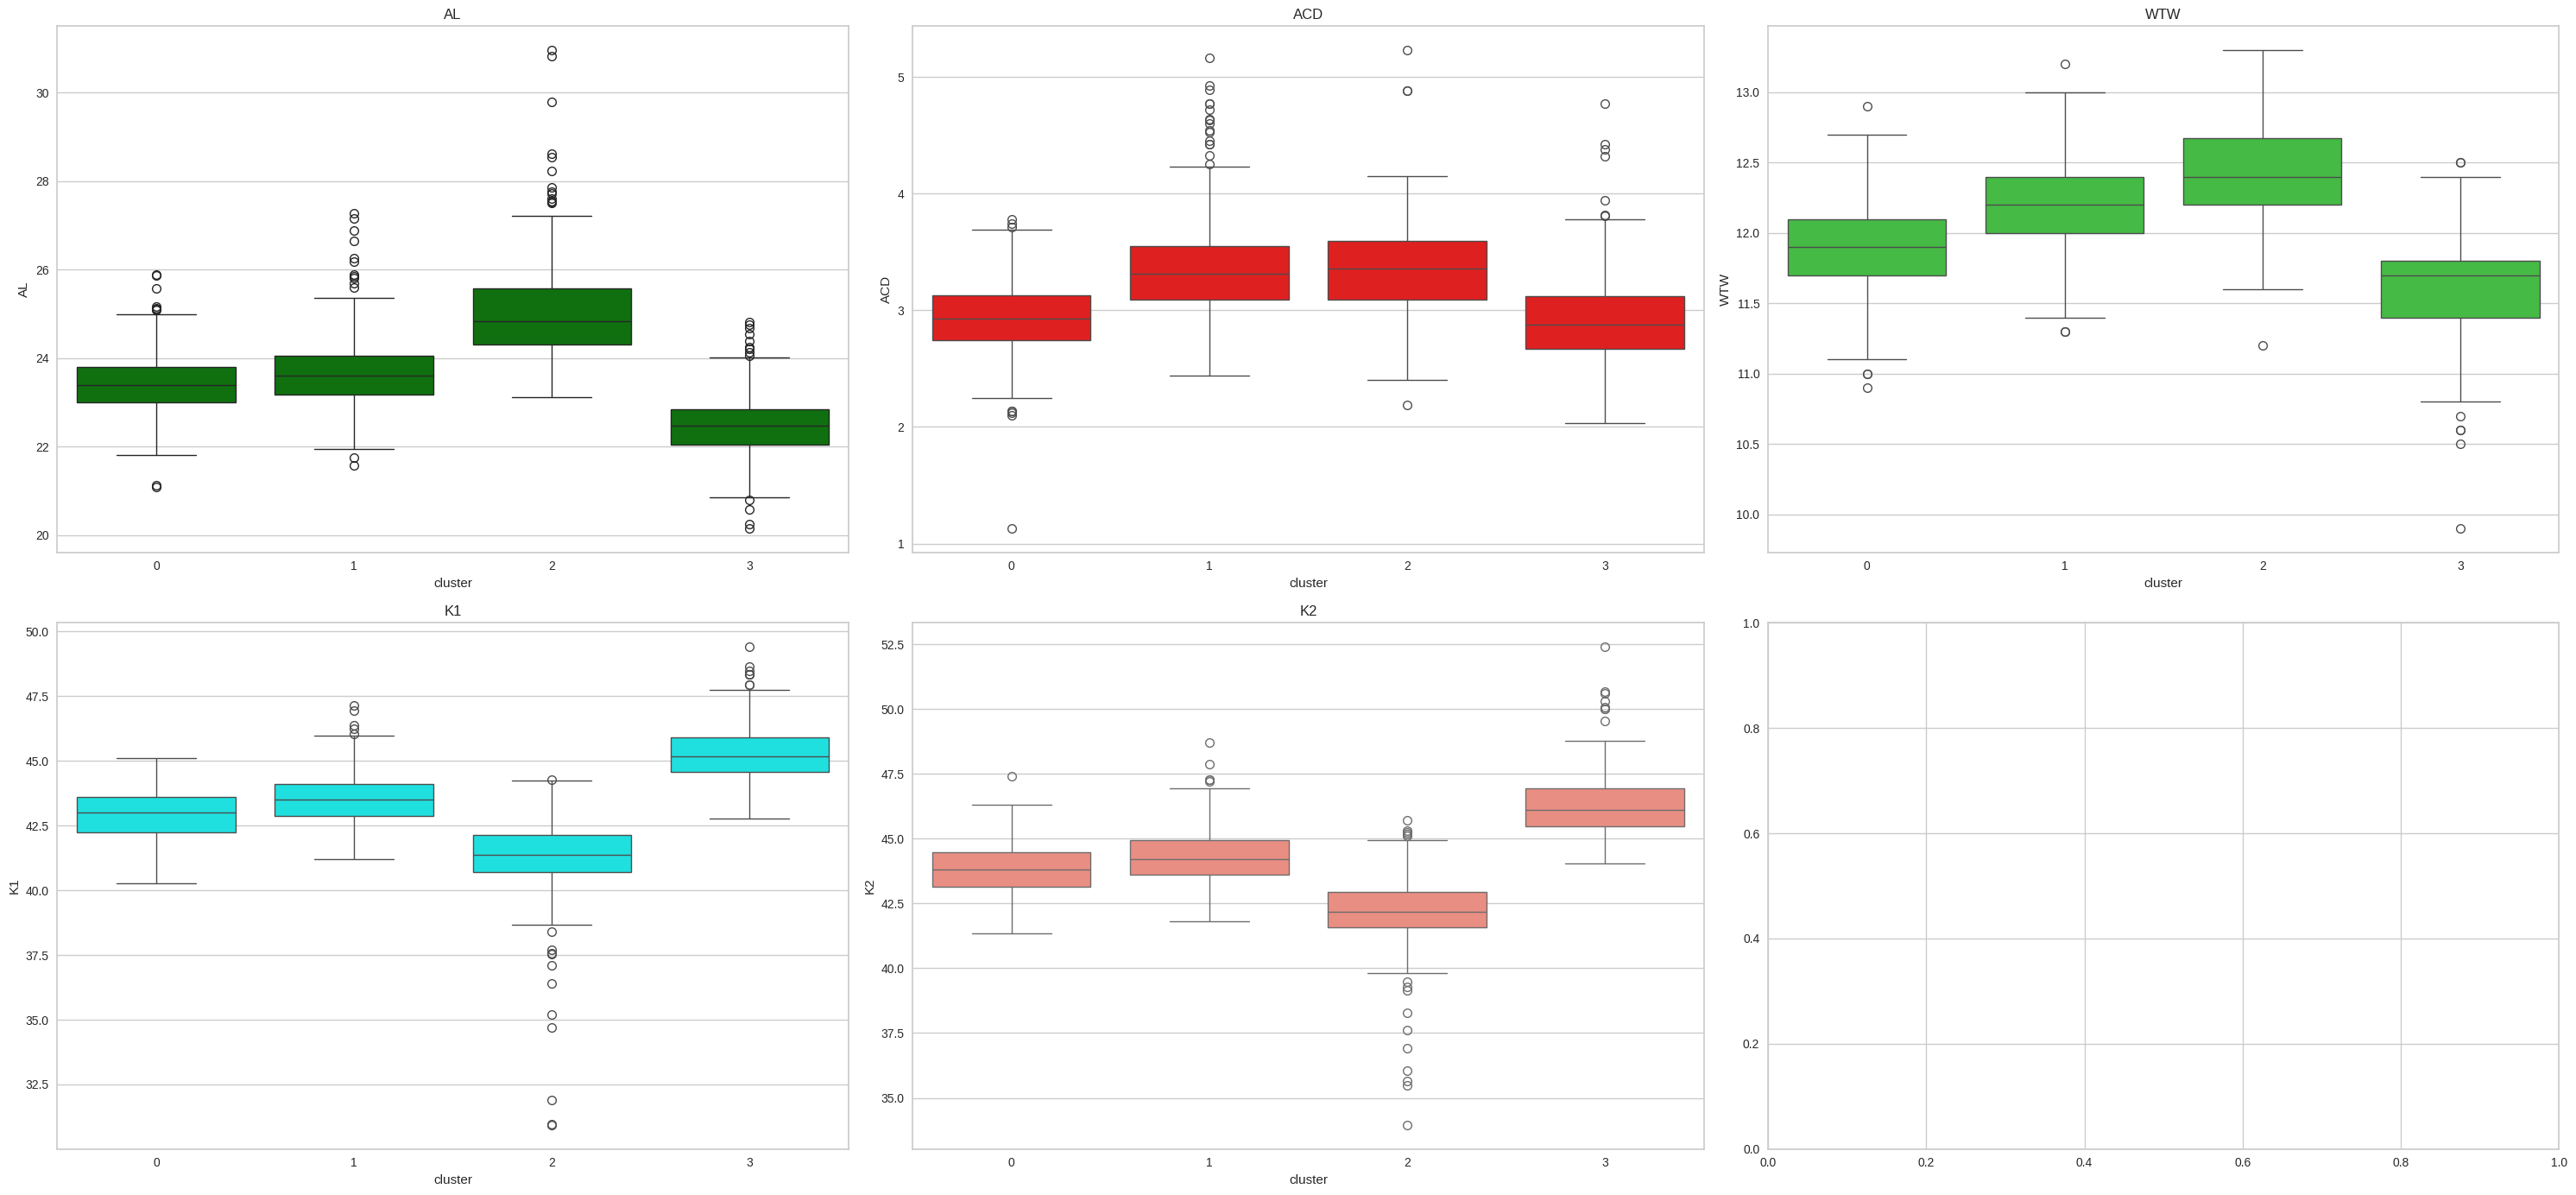

In [26]:
df['cluster'] = df_metrics['result'][0]


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6,)) = plt.subplots(2, 3, figsize=(30, 14))

sns.boxplot(x='cluster', y='AL', data=df, ax=ax1, color="green")
ax1.set_title('AL')

sns.boxplot(x='cluster', y='ACD', data=df, ax=ax2, color="red")
ax2.set_title('ACD')

sns.boxplot(x='cluster', y='WTW', data=df, ax=ax3, color="limegreen")
ax3.set_title('WTW')

sns.boxplot(x='cluster', y='K1', data=df, ax=ax4, color="cyan")
ax4.set_title('K1')

sns.boxplot(x='cluster', y='K2', data=df, ax=ax5, color="salmon")
ax5.set_title('K2')

plt.tight_layout()
plt.show()


In [21]:
df

,ID,AL,ACD,WTW,K1,K2,Correto,cluster
0,0,23.79,3.32,12.0,43.60,44.29,S,0
1,1,24.60,3.39,12.3,42.03,43.95,S,2
2,2,24.59,3.51,12.3,42.83,43.05,S,2
3,3,24.04,2.96,12.0,42.35,42.83,S,0
4,4,24.80,2.44,12.2,41.01,41.67,S,0
...,...,...,...,...,...,...,...,...
1523,1523,23.32,3.29,12.5,43.16,43.95,S,1
1524,1524,23.59,3.19,13.0,42.72,43.60,N,1
1525,1525,26.18,3.83,12.1,43.44,44.18,S,1
1526,1526,24.09,2.77,12.6,42.83,43.72,S,1
